In [308]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, \
    confusion_matrix, precision_score, recall_score

In [2]:
def print_nominative_stat(column, dropna_value=True):
    """ Функция принимает столбец с номинативными признаками и
        признак подсчёта пропущенных значений. 
        Печатает информацию о количестве каждого признака в столбце, его процентное
        содержание и общее количество всех признаков.
    """
    sns.countplot(column)
    norm = pd.DataFrame(column.value_counts(
        dropna=dropna_value, normalize=True))
    unnorm = pd.DataFrame(column.value_counts(dropna=dropna_value))
    unnorm.columns = ['number']
    unnorm.loc[:, 'percent'] = round(norm[norm.columns[0]]*100, 1)
    unnorm.loc['Total:'] = unnorm[['number', 'percent']].sum()
    print(unnorm, '\n')


def numeric_column_info(column, column_name='Data', bounds=()):
    """ Функция принимает столбец с числовым признаком, его имя 
        и предполагаемые границы изменения для отбора выбросов.
        Если границы не указаны, то отбор по IQR.
        Печатает статистические характеристики и 
        информацию о выбросах, а также рисует гистограмму распределения признака
    """
    if bounds == ():
        out_type = 'IQR'
    else:
        out_type = 'Bounds'

    values = column.count()
    null_values = column.isnull().sum()
    max_value = column.max()
    min_value = column.min()
    mean_value = round(column.mean(), 1)
    std_value = round(column.std(), 2)
    perc25 = column.quantile(0.25)
    perc50 = column.quantile(0.50)
    perc75 = column.quantile(0.75)
    IQR = column.quantile(0.75) - column.quantile(0.25)

    if out_type == 'IQR':
        left_bound = perc25 - 1.5*IQR
        right_bound = perc75 + 1.5*IQR
    elif out_type == 'Bounds':
        left_bound = bounds[0]
        right_bound = bounds[1]
    else:
        print('Unknown out_type')

    out_lower = column.loc[column < left_bound].value_counts().sum()
    out_upper = column.loc[column > right_bound].value_counts().sum()
    total_out = out_lower + out_upper
    print(f'Признак {column_name}:\n\nВсего записей: {values}\nПропущенных (null): {null_values}\n'
          f'Максимум: {max_value}\n75-й перцентиль: {perc75}\n50-й перцентиль: {perc50}\n25-й перцентиль: {perc25}\n'
          f'Минимум: {min_value}\nСреднее арифм.: {mean_value}\nСКО: {std_value}\n'
          f'IQR: {IQR}\nГраницы валидных данных: [{left_bound},{right_bound}]')

    column.loc[column.between(left_bound, right_bound)].hist(
        bins=50,
        range=(min_value, max_value),
        label=column_name + ' valid')
    if total_out == 0:
        print('\033[1;32;43mВыбросов по ' + out_type + ' не обнаружено')
    else:
        print('\033[1;31;43mОбнаружены выбросы по ' + out_type)
        print(
            f'Выбросов: {total_out}\nСверху: {out_upper}\nСнизу: {out_lower}')
        column.loc[~column.between(left_bound, right_bound)].hist(
            bins=40,
            range=(min_value, max_value),
            label=column_name + ' outlayers')
    plt.legend()


def draw_roc_auc(y_test, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

    plt.figure(figsize=(4, 4))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label=f'ROC')
    plt.title(f'AUC = {roc_auc:.4f}', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)


def print_confusion_matrix(y_test, y_pred):
    ax = plt.subplot()
    fig = plt.gcf()
    fig.set_size_inches(6, 4)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,
                fmt=".0f", linewidths=0.1, cmap="RdBu")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Real labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['no default', 'default'])
    ax.yaxis.set_ticklabels(['no default', 'default'])


def print_metrics(y_test, y_pred):
    print(pd.DataFrame({"Accuracy": [accuracy_score(y_test, y_pred)], "Precision": [precision_score(y_test, y_pred)],
                        "Recall": [recall_score(y_test, y_pred)], "F1_score": [f1_score(y_test, y_pred)]}))

#  1. Анализ данных

После загрузки данных можно сделать сделать вывод, что датасет содержит 73799 записей, при этом в нем 19 различных признаков. 

In [160]:
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Описание признаков:
+ client_id - идентификатор клиента
+ education - уровень образования
+ sex - пол заемщика
+ age - возраст заемщика
+ car - флаг наличия автомобиля
+ car_type - флаг автомобиля иномарки
+ decline_app_cnt - количество отказанных прошлых заявок
+ good_work - флаг наличия “хорошей” работы
+ bki_request_cnt - количество запросов в БКИ
+ home_address - категоризатор домашнего адреса
+ work_address - категоризатор рабочего адреса
+ income - доход заемщика
+ foreign_passport - наличие загранпаспорта
+ sna - связь заемщика с клиентами банка
+ first_time - давность наличия информации о заемщике
+ score_bki - скоринговый балл по данным из БКИ
+ region_rating - рейтинг региона
+ app_date - дата подачи заявки
+ default - флаг дефолта по кредиту

1. **client_id** - идентификатор клиента, возможно несёт в себе полезную информацию, если не является просто порядковым номером клиента. Если построить график плотности вероятности, то можно заметить, что до значений примерно 70000 процент дефолтных клиентов больше. Также стоит отметить резкий спад после 80000 для дефолтных, и, после 100000 для недефолтных клиентов. 

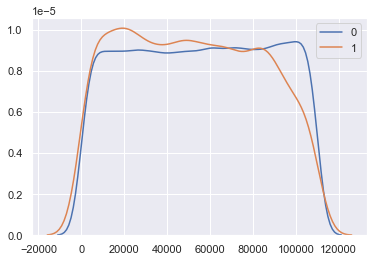

In [161]:
sns.kdeplot(data.loc[data.default == 0, 'client_id'], label="0")
sns.kdeplot(data.loc[data.default == 1, 'client_id'], label="1")

2. **education** - уровень образования клиента, категориальный признак (SCH, GRD, UGR, PGR, ACD). Наиболее часто встречается SCH.

         number  percent
SCH     38860.0     52.7
GRD     23365.0     31.7
UGR      9816.0     13.3
PGR      1257.0      1.7
NaN       307.0      0.4
ACD       194.0      0.3
Total:  73799.0    100.1 



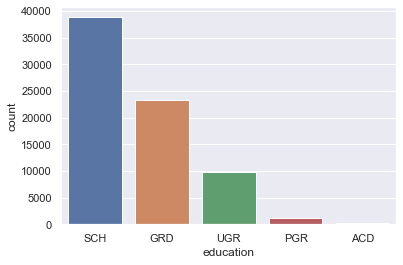

In [162]:
print_nominative_stat(data.education, dropna_value=False)

Как видно, имеются пропуски (0.4%). Заполним их наиболее часто встречающимся признаком SCH.

In [163]:
data['education'].fillna("SCH", inplace=True)

3. **sex** - пол клиента, бинарный признак (F, M). Количество жещин немного превосходит количество мужчин (56%/44%)

         number  percent
F       41562.0     56.3
M       32237.0     43.7
Total:  73799.0    100.0 



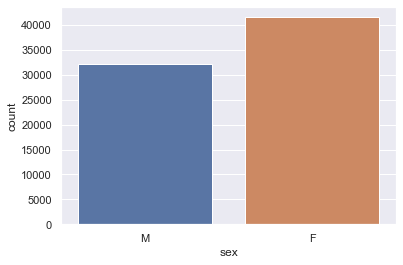

In [164]:
print_nominative_stat(data.sex)

4. **age** - возраст клиента, числовой признак. Распределение ассиметрично (отклонение влево). Кредит берут люди в возрасте от 21 до 72 лет. Среднее значение возраста заемщика - 39 лет со стандартным отклонением 11.5. Выбросов нет. 

Признак Age:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 72
75-й перцентиль: 48.0
50-й перцентиль: 37.0
25-й перцентиль: 30.0
Минимум: 21
Среднее арифм.: 39.3
СКО: 11.52
IQR: 18.0
Границы валидных данных: [3.0,75.0]
Выбросов по IQR не обнаружено


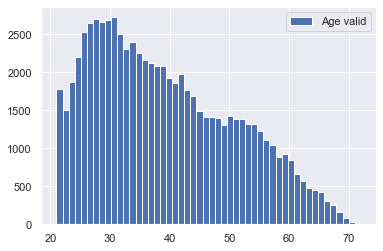

In [165]:
numeric_column_info(data.age, column_name='Age')

Логарифмирование переменной сделает её менее смещенной, что может быть хорошо для модели.

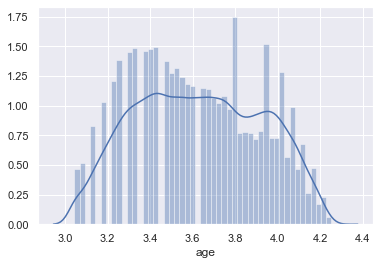

In [166]:
sns.distplot(np.log(data.age))

5. **car** - наличие авто у клиента, бинарный признак (Y, N). Большая часть заемщиков не имеет авто (67%/33%).

         number  percent
N       49832.0     67.5
Y       23967.0     32.5
Total:  73799.0    100.0 



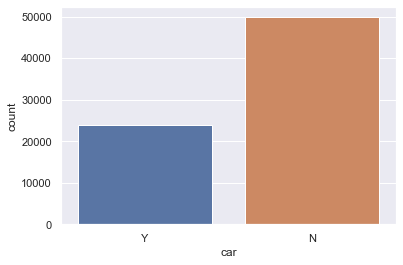

In [167]:
print_nominative_stat(data.car)

6. **car_type** - является ли авто иномаркой, бинарный признак (Y, N). Большая часть заемщиков имеет отечественное авто (81%/19%).

         number  percent
N       59791.0     81.0
Y       14008.0     19.0
Total:  73799.0    100.0 



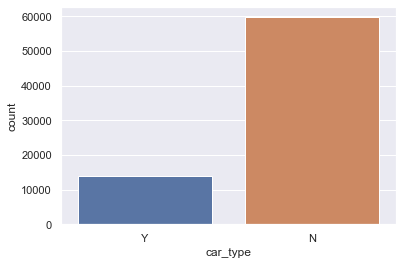

In [168]:
print_nominative_stat(data.car_type)

7. **decline_app_cnt** - количество отклоненных заявок у клиента. Числовой признак. Большая часть клиентов 81% не имеет отказов, 11% имеет один отказ, 3% - два отказа, и 1% - три отказа. Максимальное количество отказов 33. Возможно, имеет смысл удалить все записи, у которых количество отказов более 10, как выбросы. 

Признак Decline count:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 33
75-й перцентиль: 0.0
50-й перцентиль: 0.0
25-й перцентиль: 0.0
Минимум: 0
Среднее арифм.: 0.3
СКО: 0.8
IQR: 0.0
Границы валидных данных: [0,10]
Обнаружены выбросы по Bounds
Выбросов: 23
Сверху: 23
Снизу: 0


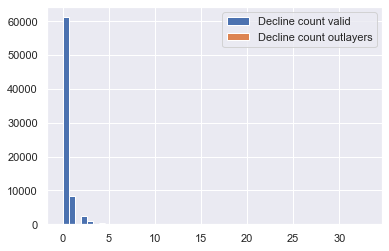

In [169]:
numeric_column_info(data.decline_app_cnt,
                    column_name='Decline count', bounds=(0, 10))

Логарифмирование переменной сделает её менее смещенной, что может быть хорошо для модели.

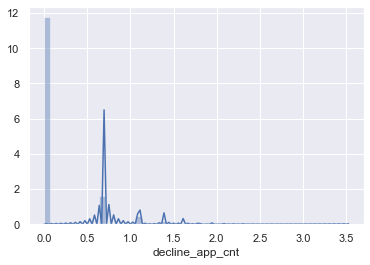

In [170]:
sns.distplot(np.log(data.decline_app_cnt+1))

8. **good_work** - наличие "хорошей" работы у клиента (0, 1). Бинарный признак. "Хорошую" работу имеет только 16% заемщиков. 

         number  percent
0       61630.0     83.5
1       12169.0     16.5
Total:  73799.0    100.0 



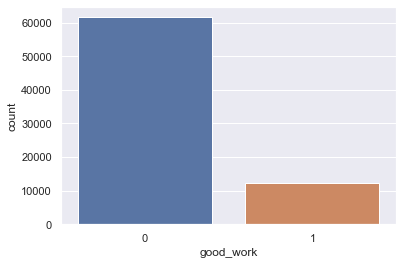

In [171]:
print_nominative_stat(data.good_work)

9. **bki_request_cnt** - количество запросов в БКИ. Числовой признак. Распределение имеет длинный "хвост". Клиентов, с количеством запросов большим, чем 12, менее половины процента. Возможно, имеет смысл удалить все записи, для которых количество обращений превосходит 12, как выбросы. 

Признак Bki request:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 53
75-й перцентиль: 3.0
50-й перцентиль: 1.0
25-й перцентиль: 0.0
Минимум: 0
Среднее арифм.: 2.0
СКО: 2.25
IQR: 3.0
Границы валидных данных: [0,12]
Обнаружены выбросы по Bounds
Выбросов: 391
Сверху: 391
Снизу: 0


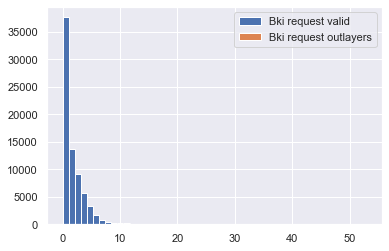

In [172]:
numeric_column_info(data.bki_request_cnt,
                    column_name='Bki request', bounds=(0, 12))

Логарифмирование переменной сделает её менее смещенной, что может быть хорошо для модели.

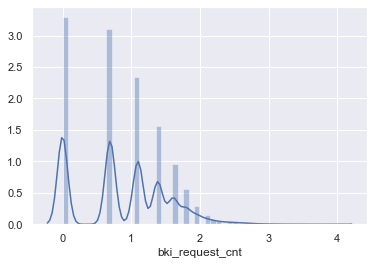

In [173]:
sns.distplot(np.log(data.bki_request_cnt+1))

10. **home_address** - признак домашнего адреса (1,2,3). Категориальный признак. Данные распределены почти поровну между 1 и 2, на 3 приходится менее 2%. Можно предположить, что 3 - это центр, 2 - около центра, 1 - далеко от центра. Действительно, большинство людей (98%) проживает не в центре.  

         number  percent
2       39956.0     54.1
1       32585.0     44.2
3        1258.0      1.7
Total:  73799.0    100.0 



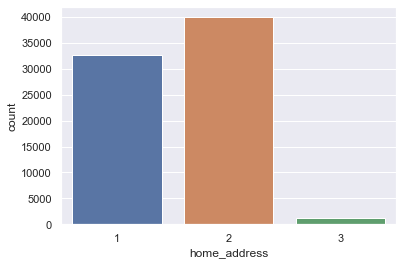

In [174]:
print_nominative_stat(data.home_address)

11. **work_address** - признак рабочего адреса (1,2,3). Категориальный признак. Можно предположить, что 3 - это центр, 2 - около центра, 3 - далеко от центра. Действительно, большинство людей (61%) работает в центре. 

         number  percent
3       44959.0     60.9
2       20506.0     27.8
1        8334.0     11.3
Total:  73799.0    100.0 



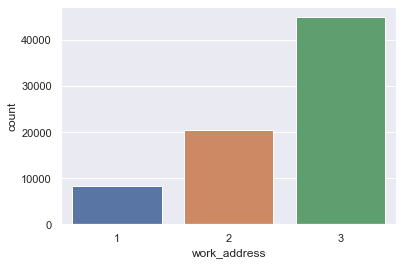

In [175]:
print_nominative_stat(data.work_address)

12. **income** - доход клиента. Числовой признак. Доход распределен неравномерно. Имеет место существенная разница между медианой (30000) и средним арифметическим (41000), так как имеют место выбросы (1000000, например). Четверть клиентов получает менее 20000. 75% клиентов получает менее 48000. Возможно, имеет смысл удалить все записи, для которых значение признака больше 100000, как выбросы. 

Признак Income:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 1000000
75-й перцентиль: 48000.0
50-й перцентиль: 30000.0
25-й перцентиль: 20000.0
Минимум: 1000
Среднее арифм.: 41099.8
СКО: 46166.32
IQR: 28000.0
Границы валидных данных: [0,100000]
Обнаружены выбросы по Bounds
Выбросов: 3139
Сверху: 3139
Снизу: 0


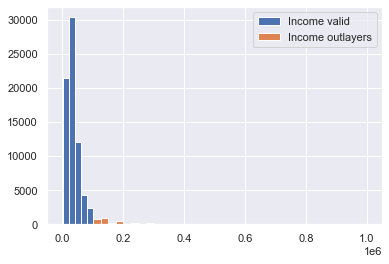

In [176]:
numeric_column_info(data.income, column_name='Income', bounds=(0, 100000))

Логарифмирование переменной сделает её менее смещенной, что может быть хорошо для модели.

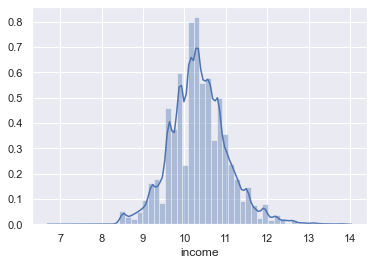

In [177]:
sns.distplot(np.log(data.income))

13. **foreign_passport** - наличие загран.паспорта у клиента (Y, N). Бинарный признак. Загран.паспорт имеет только 15% клиентов. 

         number  percent
N       62733.0     85.0
Y       11066.0     15.0
Total:  73799.0    100.0 



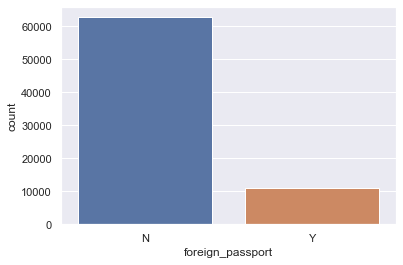

In [178]:
print_nominative_stat(data.foreign_passport)

14. **sna** - связь заемщика с клиентами банка, категориальный признак (1, 2, 3, 4).

         number  percent
1       47301.0     64.1
4       11749.0     15.9
2       10626.0     14.4
3        4123.0      5.6
Total:  73799.0    100.0 



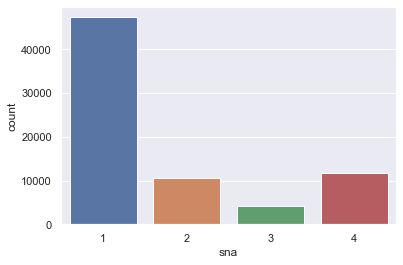

In [179]:
print_nominative_stat(data.sna, dropna_value=True)

15. **first_time** - давность наличия информации, категориальный признак (1, 2, 3, 4). Как видно из распределения, большинство заемщиков (42%) относительно давно сотрудничают с банком. 

         number  percent
3       31255.0     42.4
4       18737.0     25.4
1       12239.0     16.6
2       11568.0     15.7
Total:  73799.0    100.1 



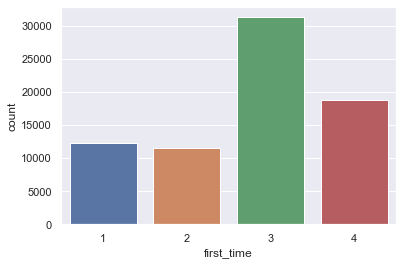

In [180]:
print_nominative_stat(data.first_time, dropna_value=True)

16. **score_bki** - скоринг-балл БКИ, числовой признак, имеет близкое к нормальному распределение со средним -1.9 и СКО 0.5. Возможно, стоит удалить записи, которые не подходят по IQR, как выбросы. 

Признак Score BKI:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 0.19977285
75-й перцентиль: -1.56983126
50-й перцентиль: -1.92082293
25-й перцентиль: -2.259533835
Минимум: -3.62458632
Среднее арифм.: -1.9
СКО: 0.5
IQR: 0.6897025750000001
Границы валидных данных: [-3.2940876975,-0.5352773974999998]
Обнаружены выбросы по IQR
Выбросов: 351
Сверху: 299
Снизу: 52


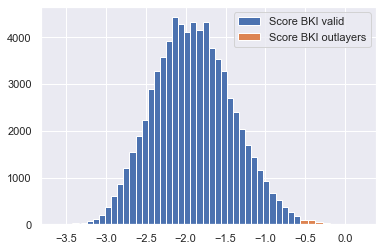

In [181]:
numeric_column_info(data.score_bki, column_name='Score BKI', bounds=())

17. **region_rating** - рейтинг региона, категориальный признак (20, 30, 40, 50, 60, 70, 80). Максимальное значение имеет рейтинг 50 (37%), рейинги 60 и 40 имеют 21% и 16% соответственно, рейтинг 80 принадлежит 15%. Рейтинги 20 и 30 составляют менее 1% выборки. 

         number  percent
50      27523.0     37.3
60      16075.0     21.8
40      12027.0     16.3
80      11469.0     15.5
70       6199.0      8.4
30        300.0      0.4
20        206.0      0.3
Total:  73799.0    100.0 



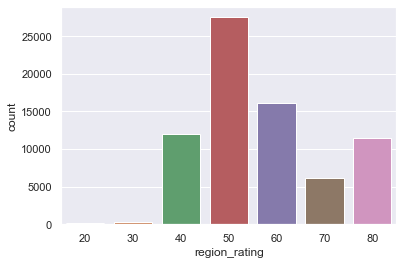

In [182]:
print_nominative_stat(data.region_rating, dropna_value=True)

18. **app_date** - дата подачи заявки. Преобразуем данные в столбце в формат DateTime. 

In [183]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

При выделении года, оказывается, что все данные представлены только 2014 годом, поэтому выделять его отдельно нет смысла

In [184]:
data['app_date'].dt.strftime('%Y').value_counts()

2014    73799
Name: app_date, dtype: int64

При выделении месяца можно видеть, что данные представлены за 4 первых месяца года, добавим этот признак в датасет под именем **month**, как категориальный. Из распределения видно, что с января по март количество заемщиков росло, а в апреле упало до уровня февраля. 

In [185]:
data['month'] = data['app_date'].dt.strftime('%m').astype('int64')

         number  percent
3       21178.0     28.7
2       18028.0     24.4
4       17683.0     24.0
1       16910.0     22.9
Total:  73799.0    100.0 



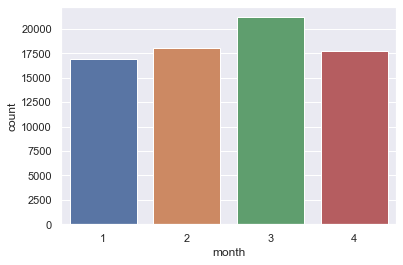

In [186]:
print_nominative_stat(data.month, dropna_value=True)

Выделим также новый признак **unix_time**, который будет содержать в себе числовое значение даты из **app_date** и удалим признак **app_date**

In [187]:
data["unix_time"] = (data["app_date"] -
                     pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

Признак unix_time:

Всего записей: 73799
Пропущенных (null): 0
Максимум: 1398816000
75-й перцентиль: 1396224000.0
50-й перцентиль: 1393891200.0
25-й перцентиль: 1391385600.0
Минимум: 1388534400
Среднее арифм.: 1393807861.5
СКО: 2775330.8
IQR: 4838400.0
Границы валидных данных: [1384128000.0,1403481600.0]
Выбросов по IQR не обнаружено


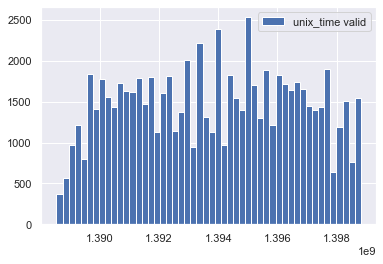

In [188]:
numeric_column_info(data.unix_time, column_name='unix_time', bounds=())

In [189]:
data = data.drop("app_date", axis=1)

19. **default** - целевая переменная, означает дефолт клиента - 1 (не вернул деньги) и 0 - (вернул деньги). Не вернули деньги только 13% клиентов. Эта выборка близка к несбалансированной, но не является таковой, если считать признаком дисбаланса отношение классов 10/1. В нашем случает отношение примерно 7/1. 

         number  percent
0       64427.0     87.3
1        9372.0     12.7
Total:  73799.0    100.0 



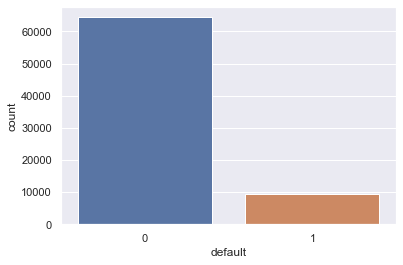

In [190]:
print_nominative_stat(data.default)

In [191]:
data.columns

Index(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'month', 'unix_time'],
      dtype='object')

### Выводы

Представленные данные довольно чистые, только один признак **education** содержал незначительное количество пропусков (менее 1%), которые были восполнены наиболее часто встречающимся значением признака. Для дальнейшего анализавсе признаки были разделены на три группы: бинарные, категориальные и числовые:

+ Бинарные (6): **sex**, **car**, **car_type**, **foreign_passport**, **good_work**, **default** (целевая)
+ Категориальные (7): **education**, **home_address**, **work_address**, **sna**, **first_time**, **region_rating**, **month**
+ Числовые (7): **age**, **decline_app_cnt**, **bki_request_cnt**, **income**, **client_id**, **score_bki**, **unix_time**

Признаки **month** и **unix_time** - производные от **app_time**. Анализ числовых переменных, таких как **age**, **decline_app_cnt**, **bki_request_cnt**, **income** показал, что логарифмирование может сделать их менее смещенными. Нельзя однозначно сказать, что является выбросом, здесь может помочь только моделирование с сопоставлением значений целевой переменной, что будет сделано в дальнейшем. Несмотря на это, стоит отметить наличие потенциально возможных выбросов в **decline_app_cnt**, **bki_request_cnt**, **income**, **score_bki**. 

Несомненно важным для задачи классификации является сбалансированность выборки относительно целевой переменной. В нашем случае выборка является несбалансированной, так как соотношение количества классов в целевой пременной **default** примерно равно 7/1. 

# 2. Оценка важности признаков 

In [192]:
binary_columns = ["sex", "car", "car_type", "foreign_passport", "good_work"]
category_columns = ["education", "home_address",
                    "work_address", "sna", "first_time", "region_rating", "month"]
numeric_columns = ["age", "decline_app_cnt", "bki_request_cnt",
                   "income", "client_id", "score_bki", "unix_time"]

Выясним, как числовые признаки влияют на нашу целевую переменную. 

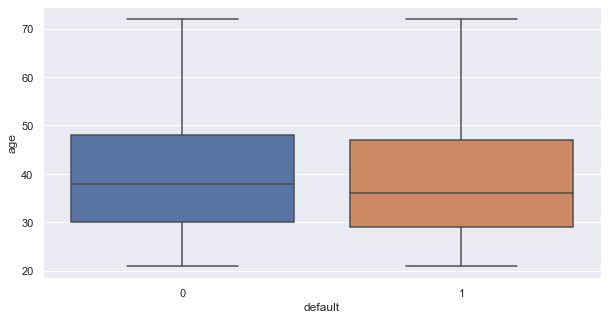

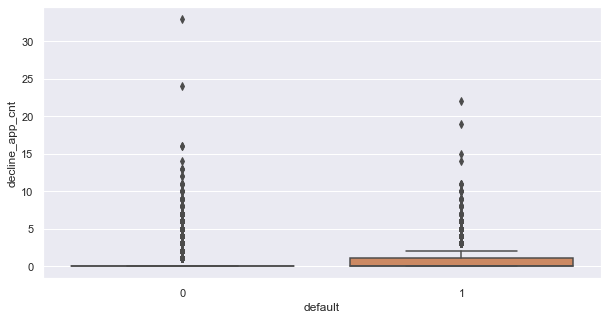

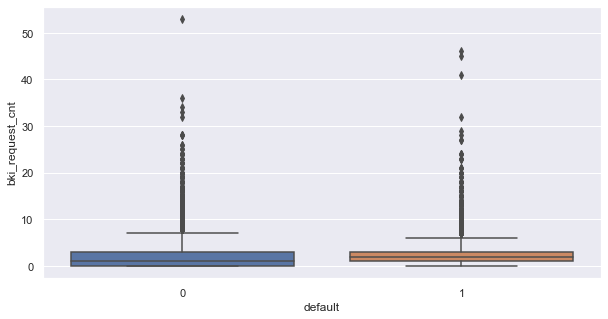

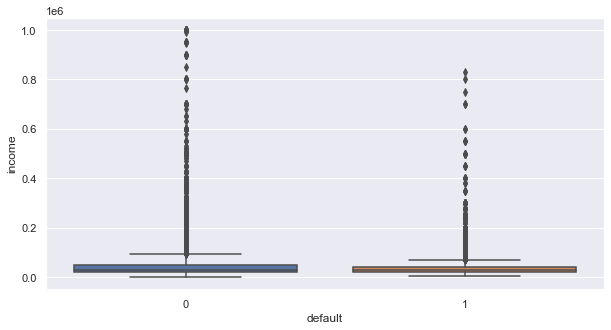

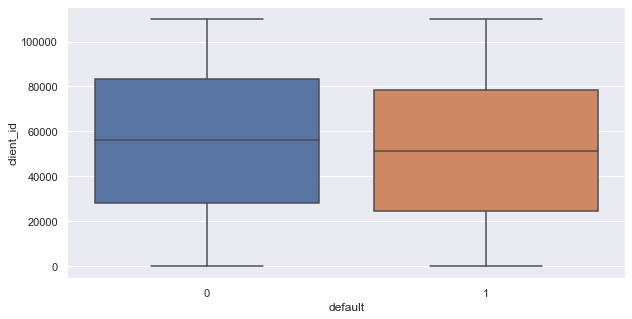

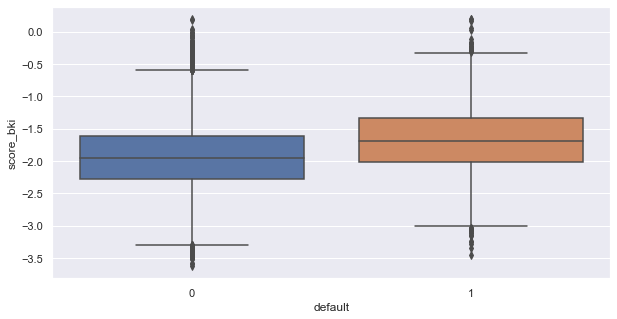

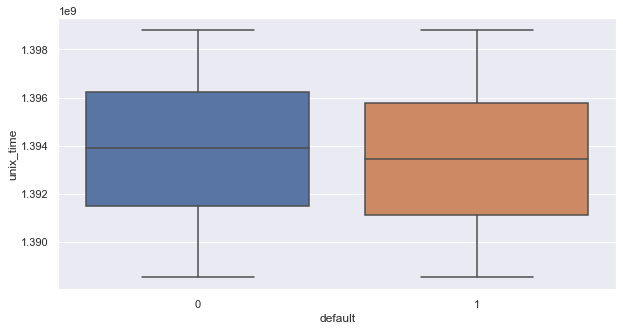

In [193]:
for col in numeric_columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(y=col, x="default", data=data, ax=ax)

In [194]:
data.groupby("default")[numeric_columns].agg(["mean"])

,age,decline_app_cnt,bki_request_cnt,income,client_id,score_bki,unix_time
,mean,mean,mean,mean,mean,mean,mean
default,,,,,,,
0,39.390504,0.240877,1.933134,41799.713288,55614.538082,-1.938048,1.393850e+09
1,38.525395,0.515472,2.462335,36288.113316,51861.805484,-1.675637,1.393521e+09


**Выводы** из распределений: Дефолтные клиенты в среднем...
    
+ **младше**
+ имеют **большее количество отмененных заявок**
+ имеют **больше запросов в БКИ**
+ имеют **более низкий доход**
+ имеют **меньшее абсолютное значение скорингового балла** БКИ

Отобразим теперь коэффициент корреляции Пирсона для числовых признаков, с целью выявления наиболее коррелирующих:

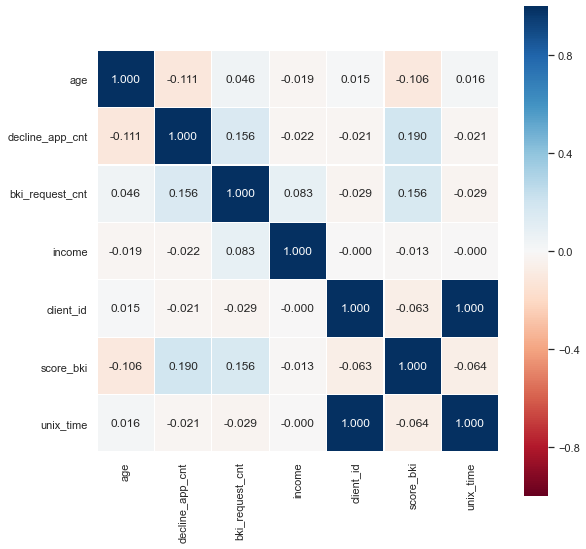

In [195]:
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(data[numeric_columns].corr(), square=True,
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1.0, vmax=1.0)

Признаки **client_id** и **unix_time** имеют большую корреляцию. Удалим признак **client_id**, чтобы избежать мультиколлинеарности. Как видим, корреляция остальных признаков слабая (min = -0.11 max = 0.19), что, несомненно, хорошо для линейной модели. 

In [196]:
data.drop("client_id", axis=1, inplace=True)
numeric_columns.remove("client_id")

Оценим значимость переменных с помощью однофакторного дисперсионного анализа (ANOVA). Из распределения важности признаков следует, что самый значимый признак - **score_bki**, самый малозначимый - **age**. Отметим, что признак **unix_time** сопоставим по значимости с признаком **income**. 

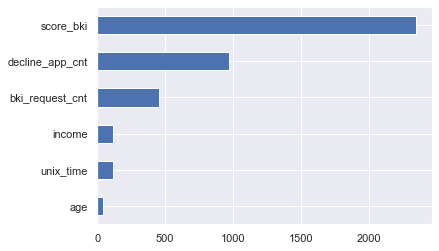

In [197]:
imp_num = Series(f_classif(data[numeric_columns], data['default'])[
                 0], index=numeric_columns)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## 2.1 Подготовка данных для моделирования

Для того, чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа. Закодируем бинарные признаки в числа при помощи LabelEncoder, который каждому значению бинарного признака сопоставит 0 или 1:

In [198]:
encoding_columns = binary_columns
label_encoder = LabelEncoder()
for num, column in enumerate(encoding_columns):
    data[column] = label_encoder.fit_transform(data[column])
    print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}


Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных. Все категориальные признаки, кроме **education** представлены в числовом формате. Преобразуем **education** в числовой формат при помощи LabelEncoder. 

In [199]:
label_encoder = LabelEncoder()
data['education'] = pd.Series(label_encoder.fit_transform(data['education']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных. Из распределения важности категориальных признаков следует, что наиболее значимыми являются **sna**, **first_time**, **region_rating**. Самый малозначимый признак - **sex**. Отметим, что признак **month** сопоставим по значимости с признаком **car**. 

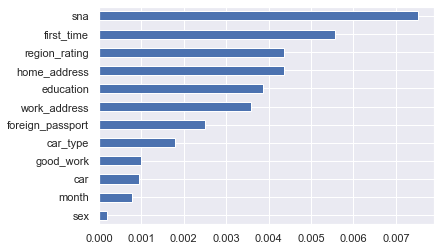

In [200]:
imp_cat = Series(mutual_info_classif(data[binary_columns + category_columns], data['default'],
                                     discrete_features=True), index=binary_columns + category_columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Закодируем категориальные переменные при помощи OneHotEncoder, а также стандартизируем числовые признаки, чтобы размах значений признака не влиял на его важность для модели:

In [201]:
X_num = StandardScaler().fit_transform(data[numeric_columns].values)
X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
    data[category_columns].values)
X = np.hstack([X_num, data[binary_columns].values, X_cat])
Y = data['default'].values

# 3. Моделирование 

## 3.1 Базовые параметры

В качестве модели используем **логистическую регрессию**. Для оценки качества модели будем использовать f1-score и roc-auc, потому как именно они являются наиболее показательными в случае классификации на несбалансированных данных. Также будем отображать и другие метрики, такие как accuracy, precision и recall.

Разделим нашу выборку на тестовую и обучающую (пока не используя предоставленные нам тестовые данные) в пропорции 2/8, обучим модель и сделаем предсказание:

   Accuracy  Precision    Recall  F1_score
0  0.874255   0.364486  0.021346  0.040331


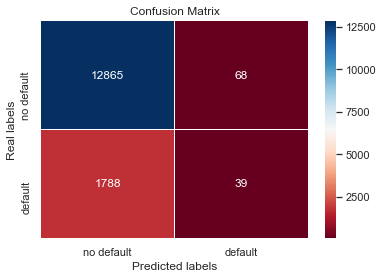

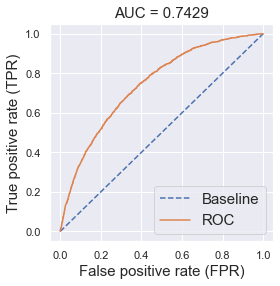

In [202]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(solver="liblinear")
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_p = model.predict_proba(X_test)
print_confusion_matrix(y_test, y_pred)
print_metrics(y_test, y_pred)
draw_roc_auc(y_test, y_pred_p)

Как и ожидалось, результаты сильно отклоняются в сторону преобладающего класса (недефолтные клиенты). Наша модель хорошо предсказывает недефолтных клиентов, но почти не определяет дефолтных. Тем не менее, полученный результат значительно лучше случайного предсказания, что хорошо видно на графике roc. Также можно видеть, насколько плоха метрика Accuracy в данном случае по сравнению с f1-score, которая ясно дает понять, что наша модель нуждается в улучшениях.  

## 3.2 Улучшение модели

Для улучшения модели предлагается:
    
1. Устранить влияние несбалансированности выборки двумя путями:
   
    + применить SMOTE (Synthetic Minority Oversampling Technique) для пополнения записей в данных миноритарного класса
    + использовать веса для классов  
  
  
2. Рассмотреть различные комбинации вариантов признаков или добавить новые
3. Подобрать оптимальные параметры регуляризации 
 
Кроме того, необходимо организовать процедуру перебора вышеобозначенных параметров. 

In [290]:
def model_create(split="SMOTE", weight=False, **kwargs):
    """ Функция принимает метод split - способ разделения выборки:
        SMOTE - разбивает данные стандартным образом и делает oversampling
        STRAT - разбивает данные на train и test стратифицированно (одинаковые доли классов)
        STANDART - разбивает данные стандартным образом

        weight - параметр, отвечающий за использование весов классов (True or False)

        Обучает логистическую регрессию на выборке из **kwargs, печатает метрики, рисует auc. 
        Возвращает обученную модель
    """
    print('Split type = ', split, '\nWeight = ', weight)

    X = kwargs['X']
    Y = kwargs['Y']

    if split == "SMOTE":
        os = SMOTE(random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.2, random_state=42)
        X_train, y_train = os.fit_sample(X_train, y_train)
    elif split == "STRAT":
        sss = StratifiedShuffleSplit(
            n_splits=1, test_size=0.2,  random_state=42)
        train_indices, test_indices = [split for split in sss.split(X, Y)][0]
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = Y[train_indices]
        y_test = Y[test_indices]
    elif split == "STANDART":
        X_train, X_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.2, random_state=42)
    else:
        print("Unknown split type")
        return 0

    if weight:
        model = LogisticRegression(
            solver="liblinear", class_weight={0: 1, 1: 6.8}, C=0.03, max_iter=10000)
    else:
        model = LogisticRegression(solver="liblinear")

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_p = model.predict_proba(X_test)
    print_confusion_matrix(y_test, y_pred)
    print_metrics(y_test, y_pred)
    draw_roc_auc(y_test, y_pred_p)

    return model

### 3.2.1 Устранение дисбаланса выборки

+ **preprocessing_1** -  подготовка данных аналогичная baseline, описанному выше:

In [49]:
def preprocessing_1(data_type="train"):
    """ Функция принимает data_type: 
        "train" - для обучающей выборки
        "test" - для тестовой выборки
        Осуществляет соответствующую настройку параметров и возвращает:
        подготовленные признаки X
        целевую переменную Y в случае "train"
        или идентификатор клиента в случае "test"
    """
    binary_columns = ["sex", "car", "car_type",
                      "foreign_passport", "good_work"]
    category_columns = ["education", "home_address",
                        "work_address", "sna", "first_time", "region_rating", "month"]
    numeric_columns = ["age", "decline_app_cnt", "bki_request_cnt",
                       "income", "score_bki", "unix_time"]

    # Чтение данных и заполнение пропусков
    if data_type == "train":
        data = pd.read_csv("train.csv")
    elif data_type == "test":
        data = pd.read_csv("test.csv")
    else:
        print("Unknown data_type")
        return 0

    data['education'].fillna("SCH", inplace=True)

    # Создание новых признаков
    data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
    data['month'] = data['app_date'].dt.strftime('%m').astype('int64')
    data["unix_time"] = (data["app_date"] -
                         pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = data.drop("app_date", axis=1)

    # Кодировка бинарных признаков
    encoding_columns = binary_columns
    label_encoder = LabelEncoder()
    for num, column in enumerate(encoding_columns):
        data[column] = label_encoder.fit_transform(data[column])

    # Кодировка категориальных признаков
    X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
        data[category_columns].values)

    # Стандартизация числовых признаков
    X_num = StandardScaler().fit_transform(data[numeric_columns].values)

    # Создание таблицы признаков и столбца целевой переменной
    X = np.hstack([X_num, data[binary_columns].values, X_cat])

    if data_type == "train":
        Y = data['default'].values
        return {'X': X, 'Y': Y}
    elif data_type == "test":
        Y = data['client_id'].values
        return X, Y
    else:
        print("Unknown data_type")
        return 0

Рассмотрим вариант с использованием весов классов и стандартного разбиения выборки:

Split type =  STANDART 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.673645   0.226891  0.679803  0.340227


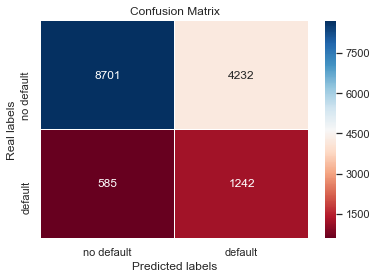

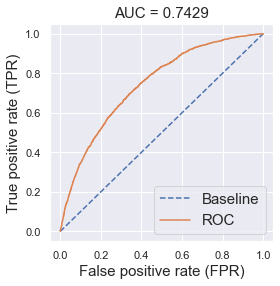

In [59]:
model = model_create("STANDART", True, **preprocessing_1(data_type="train"))

Использование весов класса позволило значительно улучшить F1-score (0.34 против 0.04), roc-auc практически не изменился.

Рассмотрим вариант с использованием SMOTE:

Split type =  SMOTE 
Weight =  False
   Accuracy  Precision    Recall  F1_score
0    0.6729   0.226236  0.678708  0.339354


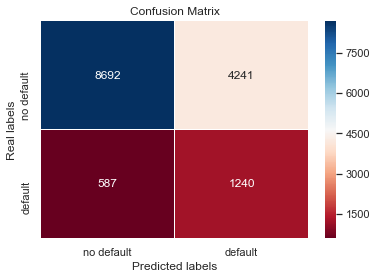

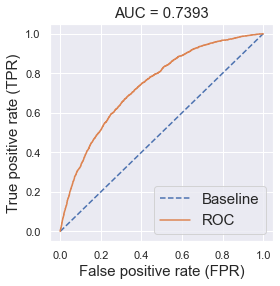

In [304]:
model = model_create("SMOTE", False, **preprocessing_1(data_type="train"))

Использование SMOTE не позволило улучшить F1-score, но что хуже - обнаружилось падение roc-auc (0.7393 против 0.7426).  

Рассмотрим вариант с использованием стратифицированной выборки и весов классов:

Split type =  STRAT 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.673103   0.229811  0.669691  0.342195


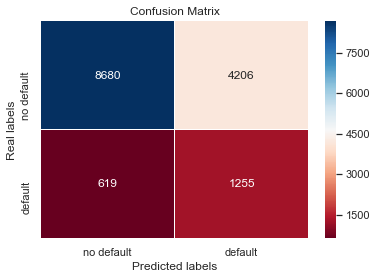

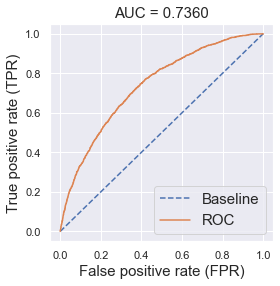

In [61]:
model = model_create("STRAT", True, **preprocessing_1(data_type="train"))

Использование стратифицированной выборки позволило немного улучшить F1-score, но что хуже - обнаружилось падение roc-auc (0.736 против 0.7426).  

Описанные выше эксперименты над устранением дисбаланса выборки позволили сделать вывод: большой разницы между SMOTE и использованием весов классов на стандартном наборе признаков (baseline) не выявлено. В дальнейших исследованиях предполагается использование весов классов. 

### 3.2.2 Подбор оптимальных признаков

+ **preprocessing_2** -  подготовка данных аналогичная baseline, исправлено: логарифмирование признаков 

In [225]:
def preprocessing_2(data_type="train"):
    """ Функция принимает data_type: 
        "train" - для обучающей выборки
        "test" - для тестовой выборки
        Осуществляет соответствующую настройку параметров и возвращает:
        подготовленные признаки X
        целевую переменную Y в случае "train"
        или идентификатор клиента в случае "test"
    """
    binary_columns = ["sex", "car", "car_type",
                      "foreign_passport", "good_work"]
    category_columns = ["education", "home_address",
                        "work_address", "sna", "first_time", "region_rating", "month"]
    numeric_columns = ["age", "decline_app_cnt", "bki_request_cnt",
                       "income", "score_bki", "unix_time"]

    # Чтение данных и заполнение пропусков
    if data_type == "train":
        data = pd.read_csv("train.csv")
    elif data_type == "test":
        data = pd.read_csv("test.csv")
    else:
        print("Unknown data_type")
        return 0

    data['education'].fillna("SCH", inplace=True)

    # Создание новых признаков
    data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
    data['month'] = data['app_date'].dt.strftime('%m').astype('int64')
    data["unix_time"] = (data["app_date"] -
                         pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = data.drop("app_date", axis=1)

    # Логарифмирование признаков
    data.age = np.log(data.age)
    data.income = np.log(data.income+1)
    data.bki_request_cnt = np.log(data.bki_request_cnt+1)
    data.decline_app_cnt = np.log(data.decline_app_cnt+1)

    # Кодировка бинарных признаков
    encoding_columns = binary_columns
    label_encoder = LabelEncoder()
    for num, column in enumerate(encoding_columns):
        data[column] = label_encoder.fit_transform(data[column])

    # Кодировка категориальных признаков
    X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
        data[category_columns].values)

    # Стандартизация числовых признаков
    X_num = StandardScaler().fit_transform(data[numeric_columns].values)

    # Создание таблицы признаков и столбца целевой переменной
    X = np.hstack([X_num, data[binary_columns].values, X_cat])

    if data_type == "train":
        Y = data['default'].values
        return {'X': X, 'Y': Y}
    elif data_type == "test":
        Y = data['client_id'].values
        return X, Y
    else:
        print("Unknown data_type")
        return 0

Split type =  STANDART 
Weight =  True
   Accuracy  Precision   Recall  F1_score
0  0.671341    0.22559  0.68035  0.338831


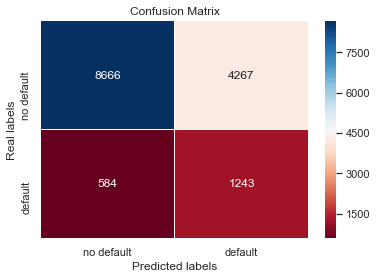

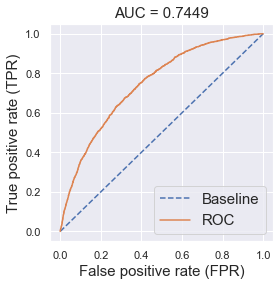

In [63]:
model = model_create("STANDART", True, **preprocessing_2(data_type="train"))

Логарифмирование признаков **age**, **decline_app_cnt**, **bki_request_cnt**, **income** позволило улучшить показатель roc-auc c 0.7429 до 0.7449.

+ **preprocessing_3** -  подготовка данных аналогичная baseline, исправлено: логарифмирование признаков + выбросы

In [235]:
def preprocessing_3(data_type="train"):
    """ Функция принимает data_type: 
        "train" - для обучающей выборки
        "test" - для тестовой выборки
        Осуществляет соответствующую настройку параметров и возвращает:
        подготовленные признаки X
        целевую переменную Y в случае "train"
        или идентификатор клиента в случае "test"
    """
    binary_columns = ["sex", "car", "car_type",
                      "foreign_passport", "good_work"]
    category_columns = ["education", "home_address",
                        "work_address", "sna", "first_time", "region_rating", "month"]
    numeric_columns = ["age", "decline_app_cnt", "bki_request_cnt",
                       "income", "score_bki", "unix_time"]

    # Чтение данных и заполнение пропусков
    if data_type == "train":
        data = pd.read_csv("train.csv")
    elif data_type == "test":
        data = pd.read_csv("test.csv")
    else:
        print("Unknown data_type")
        return 0

    data['education'].fillna("SCH", inplace=True)

    # Удаление выбросов по порогу
    data = data[data.income <= 100000]
    data = data[data.bki_request_cnt <= 10]
    data = data[data.decline_app_cnt <= 12]

    # Создание новых признаков
    data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
    data['month'] = data['app_date'].dt.strftime('%m').astype('int64')
    data["unix_time"] = (data["app_date"] -
                         pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = data.drop("app_date", axis=1)

    # Логарифмирование признаков
    data.age = np.log(data.age)
    data.income = np.log(data.income+1)
    data.bki_request_cnt = np.log(data.bki_request_cnt+1)
    data.decline_app_cnt = np.log(data.decline_app_cnt+1)

    # Кодировка бинарных признаков
    encoding_columns = binary_columns
    label_encoder = LabelEncoder()
    for num, column in enumerate(encoding_columns):
        data[column] = label_encoder.fit_transform(data[column])

    # Кодировка категориальных признаков
    X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
        data[category_columns].values)

    # Стандартизация числовых признаков
    X_num = StandardScaler().fit_transform(data[numeric_columns].values)

    # Создание таблицы признаков и столбца целевой переменной
    X = np.hstack([X_num, data[binary_columns].values, X_cat])

    if data_type == "train":
        Y = data['default'].values
        return {'X': X, 'Y': Y}
    elif data_type == "test":
        Y = data['client_id'].values
        return X, Y
    else:
        print("Unknown data_type")
        return 0

Split type =  STANDART 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.675425   0.227617  0.673176  0.340203


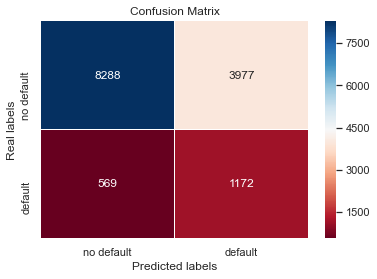

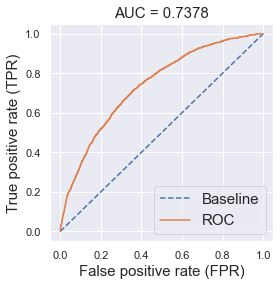

In [236]:
model = model_create("STANDART", True, **preprocessing_3(data_type="train"))

Добавление к логарифмированию признаков отбраковки по порогам не позволили улучшить результат метрики roc-auc. Лучшее, что удалось подобрать перебором 0.7378. 

+ **preprocessing_4** -  подготовка данных аналогичная baseline, исправлено: логарифмирование признаков + только самые важные признаки

In [66]:
def preprocessing_4(data_type="train"):
    """ Функция принимает data_type: 
        "train" - для обучающей выборки
        "test" - для тестовой выборки
        Осуществляет соответствующую настройку параметров и возвращает:
        подготовленные признаки X
        целевую переменную Y в случае "train"
        или идентификатор клиента в случае "test"
    """

    category_columns = ["sna", "first_time", "region_rating"]
    numeric_columns = ["decline_app_cnt", "bki_request_cnt",
                       "score_bki"]

    # Чтение данных и заполнение пропусков
    if data_type == "train":
        data = pd.read_csv("train.csv")
    elif data_type == "test":
        data = pd.read_csv("test.csv")
    else:
        print("Unknown data_type")
        return 0

    data['education'].fillna("SCH", inplace=True)

    # Создание новых признаков
    data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
    data['month'] = data['app_date'].dt.strftime('%m').astype('int64')
    data["unix_time"] = (data["app_date"] -
                         pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = data.drop("app_date", axis=1)

    # Логарифмирование признаков
    data.bki_request_cnt = np.log(data.bki_request_cnt+1)
    data.decline_app_cnt = np.log(data.decline_app_cnt+1)

    # Кодировка категориальных признаков
    X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
        data[category_columns].values)

    # Стандартизация числовых признаков
    X_num = StandardScaler().fit_transform(data[numeric_columns].values)

    # Создание таблицы признаков и столбца целевой переменной
    X = np.hstack([X_num,  X_cat])

    if data_type == "train":
        Y = data['default'].values
        return {'X': X, 'Y': Y}
    elif data_type == "test":
        Y = data['client_id'].values
        return X, Y
    else:
        print("Unknown data_type")
        return 0

Split type =  STANDART 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.655149   0.209024  0.641489  0.315308


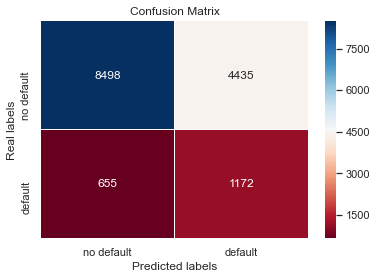

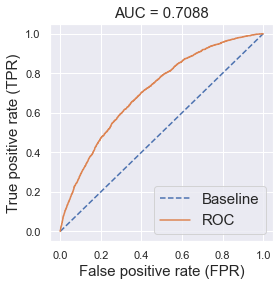

In [67]:
model = model_create("STANDART", True, **preprocessing_4(data_type="train"))

Использование тройки самых значимых категориальных и числовых признаков не улучшили значение метрики roc-auc 0.7088. 

**Вывод**: из использованных приемов улучшения качества модели наилучшим оказалось логарифмирование признаков (preprocessing_2). Такие варианты как устранение выбросов и выбор только значимых признаков улучшения метрики roc-auc не дали. 

### 3.2.3 Подбор гиперпараметров

Проведем подбор гиперпараметров модели для полученного ранее оптимального варианта (STANDART, weight = true, preprocessing_2)

In [433]:
def grid_search_func(weight=False, hyperparameters={}, **kwargs):

    X = kwargs['X']
    Y = kwargs['Y']

    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)
    model = LogisticRegression(solver="liblinear", class_weight={0: 1, 1: 6.8})
    model.fit(X_train, y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    clf = GridSearchCV(model, hyperparameters, cv=5,
                       verbose=0, scoring="roc_auc")
    best_model = clf.fit(X_train, y_train)
    # View best hyperparameters
    print('Лучшее Penalty:',
          best_model.best_estimator_.get_params()['penalty'])
    print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
    print('Лучший roc_auc:', best_model.best_score_)
    print("Значения метрик на отложенной выборке:")
    y_pred = best_model.predict(X_test)
    print_metrics(y_test, y_pred)
    print('Таблица тестов:')

    return pd.DataFrame(best_model.cv_results_)

Подбор гиперпараметров происходил в два этапа: на обоих исследовалось два вида регуляризации 'l1', 'l2'. Но на первом этапе набор констант был [0.1, 0.5, 1, 2, 4, 10, 20, 50, 100] и алгоритм поиска признал оптимальным 0.1,что означало, что надо поискать еще. На втором этапе набор констант был [0.01, 0.03, 0.05, 0.08] и лучшим оказался вариант 0.03. Во обоих случаях лучшим регуляризатором был 'l2'. Регуляризация осуществлялась на данных prepprocessing_2. 

In [438]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
# C = [0.1, 0.5, 1, 2, 4, 10, 20, 50, 100]; --> 0.1 & l2
C = [0.01, 0.03, 0.05, 0.08]  # C : 0.03 penalty: l2
# Создадим гиперпараметры
hyperprm = dict(C=C, penalty=penalty)

grid_search_func(weight=True, hyperparameters=hyperprm, **preprocessing_2())

Лучшее Penalty: l2
Лучшее C: 0.03
Лучший roc_auc: 0.7325472014860792
Значения метрик на отложенной выборке:
   Accuracy  Precision   Recall  F1_score
0  0.671341    0.22559  0.68035  0.338831
Таблица тестов:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.136722,0.642301,0.033802,0.016655,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.731822,0.726477,0.734879,0.727462,0.738164,0.731761,0.004407,8
1,1.110263,0.097137,0.030202,0.010477,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.732080,0.727223,0.735686,0.728150,0.739244,0.732477,0.004529,4
2,3.086377,1.915294,0.020801,0.000400,0.03,l1,"{'C': 0.03, 'penalty': 'l1'}",0.732027,0.726697,0.735450,0.727899,0.739199,0.732254,0.004655,7
3,1.082662,0.020442,0.019801,0.000400,0.03,l2,"{'C': 0.03, 'penalty': 'l2'}",0.731815,0.727311,0.735892,0.728238,0.739479,0.732547,0.004599,1
4,5.848935,6.382769,0.021401,0.001020,0.05,l1,"{'C': 0.05, 'penalty': 'l1'}",0.731898,0.726945,0.735639,0.727933,0.739436,0.732370,0.004689,6
5,1.280473,0.135750,0.021801,0.001939,0.05,l2,"{'C': 0.05, 'penalty': 'l2'}",0.731664,0.727350,0.735955,0.728242,0.739506,0.732543,0.004613,2
6,7.123607,5.706309,0.021601,0.001744,0.08,l1,"{'C': 0.08, 'penalty': 'l1'}",0.731706,0.727174,0.735766,0.728004,0.739510,0.732432,0.004669,5
7,1.262872,0.085931,0.023401,0.005817,0.08,l2,"{'C': 0.08, 'penalty': 'l2'}",0.731531,0.727377,0.735989,0.728254,0.739522,0.732535,0.004619,3


Также был осуществлен подбор параметров регуляризации для обработки данных preprocessing_3, что дало аналогичный предыдущему результат.

In [456]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']
# Зададим ограничения для параметра регуляризации
C = [0.01, 0.03, 0.05, 0.1, 0.5, 1, 2, 4, 10]  # C : 0.03 penalty : l2
# Создадим гиперпараметры
hyperprm = dict(C=C, penalty=penalty)

grid_search_func(weight=True, hyperparameters=hyperprm, **preprocessing_3())

Лучшее Penalty: l2
Лучшее C: 0.03
Лучший roc_auc: 0.7303387238691024
Значения метрик на отложенной выборке:
   Accuracy  Precision    Recall  F1_score
0  0.675425   0.227723  0.673751  0.340395
Таблица тестов:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.726899,0.527955,0.029802,0.018138,0.01,l1,"{'C': 0.01, 'penalty': 'l1'}",0.725506,0.723729,0.737156,0.734648,0.728738,0.729955,0.005175,18
1,0.943654,0.023671,0.029002,0.014044,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.725369,0.724637,0.737284,0.734838,0.729358,0.730297,0.005033,14
2,2.471541,1.055234,0.036002,0.030022,0.03,l1,"{'C': 0.03, 'penalty': 'l1'}",0.725481,0.724029,0.737144,0.735105,0.729266,0.730205,0.005167,17
3,1.188468,0.083265,0.031002,0.013372,0.03,l2,"{'C': 0.03, 'penalty': 'l2'}",0.725335,0.724517,0.737309,0.735164,0.729368,0.730339,0.005133,1
4,2.976370,0.732607,0.024601,0.003200,0.05,l1,"{'C': 0.05, 'penalty': 'l1'}",0.725429,0.724232,0.737156,0.735212,0.729266,0.730259,0.005152,16
5,1.076262,0.032782,0.021201,0.002926,0.05,l2,"{'C': 0.05, 'penalty': 'l2'}",0.725304,0.724481,0.737318,0.735225,0.729347,0.730335,0.005162,2
6,10.365193,4.346210,0.023201,0.003060,0.1,l1,"{'C': 0.1, 'penalty': 'l1'}",0.725334,0.724357,0.737236,0.735254,0.729303,0.730297,0.005170,15
7,1.114664,0.033400,0.020001,0.000632,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.725253,0.724434,0.737320,0.735280,0.729330,0.730323,0.005194,3
8,10.549003,2.546193,0.021201,0.000980,0.5,l1,"{'C': 0.5, 'penalty': 'l1'}",0.725230,0.724387,0.737307,0.735320,0.729307,0.730310,0.005215,5
9,1.122864,0.048560,0.019801,0.000748,0.5,l2,"{'C': 0.5, 'penalty': 'l2'}",0.725219,0.724385,0.737320,0.735325,0.729307,0.730311,0.005222,4


In [301]:
def preprocessing_5(data_type="train"):
    """ Функция принимает data_type: 
        "train" - для обучающей выборки
        "test" - для тестовой выборки
        Осуществляет соответствующую настройку параметров и возвращает:
        подготовленные признаки X
        целевую переменную Y в случае "train"
        или идентификатор клиента в случае "test"
    """
    binary_columns = ["sex", "car", "car_type",
                      "foreign_passport", "good_work"]
    category_columns = ["education", "home_address",
                        "work_address", "sna", "first_time", "region_rating", "month"]
    numeric_columns = ["age", "decline_app_cnt", "bki_request_cnt",
                       "income", "score_bki", "unix_time"]

    # Чтение данных и заполнение пропусков
    if data_type == "train":
        data = pd.read_csv("train.csv")
    elif data_type == "test":
        data = pd.read_csv("test.csv")
    else:
        print("Unknown data_type")
        return 0

    data['education'].fillna("SCH", inplace=True)

    # Удаление выбросов по порогу
    data = data[data.income <= 100000]
    data = data[data.bki_request_cnt <= 10]
    data = data[data.decline_app_cnt <= 12]

    # Создание новых признаков
    data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
    data['month'] = data['app_date'].dt.strftime('%m').astype('int64')
    data["unix_time"] = (data["app_date"] -
                         pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    data = data.drop("app_date", axis=1)

    # Логарифмирование признаков
    data.age = np.log(data.age)
    data.income = np.log(data.income+1)
    data.bki_request_cnt = np.log(data.bki_request_cnt+1)
    data.decline_app_cnt = np.log(data.decline_app_cnt+1)

    # Кодировка бинарных признаков
    encoding_columns = binary_columns
    label_encoder = LabelEncoder()
    for num, column in enumerate(encoding_columns):
        data[column] = label_encoder.fit_transform(data[column])

    # Кодировка категориальных признаков
    X_cat = OneHotEncoder(sparse=False, categories='auto').fit_transform(
        data[category_columns].values)

    # Стандартизация числовых признаков
    X_num = StandardScaler().fit_transform(data[numeric_columns].values)

    # Создание таблицы признаков и столбца целевой переменной
    X = np.hstack([X_num, data[binary_columns].values, X_cat])

    if data_type == "train":
        Y = data['default'].values
        return {'X': X, 'Y': Y}
    elif data_type == "test":
        Y = data['client_id'].values
        return X, Y
    else:
        print("Unknown data_type")
        return 0

Применение оптимальных параметров регуляризации позволило немного улучшить предыдущий результат метрики roc-auc до 0.7449.

Split type =  STANDART 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.675425   0.227723  0.673751  0.340395


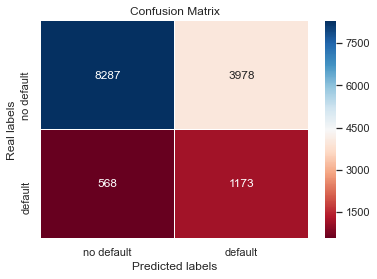

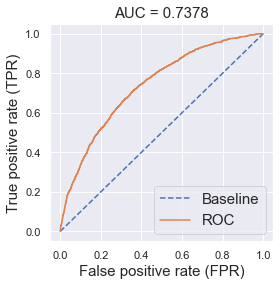

In [302]:
model = model_create("STANDART", True, **preprocessing_5(data_type="train"))

# 4. Запись результата для submission на kaggle

Split type =  STANDART 
Weight =  True
   Accuracy  Precision    Recall  F1_score
0  0.675425   0.227723  0.673751  0.340395


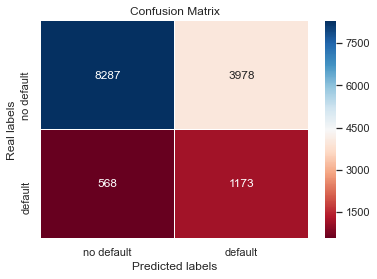

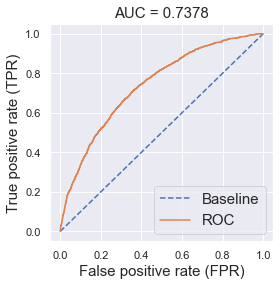

In [303]:
# выполним обучение модели с параметрами, описанными в preprocessing
model = model_create("STANDART", True, **preprocessing_3(data_type="train"))
# обработаем тестовую выборку с помощью соответствующего preprocessing
X_test, client_id = preprocessing_2(data_type="test")
# сделаем предсказание, сформируем dataframe с ответами
y_pred_p = model.predict_proba(X_test)
result = np.vstack([client_id, y_pred_p[:, 1]]).T
df = pd.DataFrame(result, columns=["client_id", "default"])
df["client_id"] = df["client_id"].astype('int64')
# сохраним sample_submission.csv для отправки на kaggle
df.to_csv("sample_submission.csv", index=False)

#  5. Kaggle результаты

Наилучший результат, полученный в соревновании на Kaggle = **0.73761** (ROC-AUC).

Этот результат получен на preprocessing_3 и показан в пункте 4. 
Многие из проведенных экспериментов не отображены в данном ноутбуке. Но вот некоторые размышления:

+ Более высокий показатель метрики roc-auc в ноутбуке не значит более высокий показатель на Kaggle
+ Ни один из использованных вариантов удаления малозначимых признаков не привел к улучшению метрики в ноутбуке 
+ Использование SMOTE дало хороший (0.7393) результат в ноутбуке, но почти что один из самых малых на Kaggle (0.733) 
+ Другие модели, такие как RandomForest и KNeighborsClassifier работают на наших данных хуже, чем Logistic Regression
+ Использование PCA также не дало положительных результатов